<a href="https://colab.research.google.com/github/Pablo1990/3D-deep-segmentation-protocol/blob/main/3D_deep_segmentation_protocol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D deep segmentation protocol

Mount your google drive to access all your image files, segmentations, and custom models. This also ensures that any models you train are saved to your google drive. If you'd like to try out the notebook without your own files, please download the sample images from tissuenet (optional step in Setup below).

This notebook was inspired by Cellpose 2.0 notebook (https://github.com/MouseLand/cellpose) and the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories.

# 0. Installation setup

We will first install cellpose 2.0, check the GPU is working, and mount google drive to get your models and images.

## Installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [74]:
#!pip install "opencv-python-headless<4.3"
!pip install cellpose matplotlib plotly scikit-learn

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.4 MB/s eta 0:00:00


(RECOMENDED) You can also connect google colab to your own computer in case you have a GPU by following: https://research.google.com/colaboratory/local-runtimes.html

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [5]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

/bin/bash: nvcc: command not found
Tue Nov  5 09:46:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 5000                On  | 00000000:65:00.0  On |                  Off |
| 34%   38C    P5              28W / 230W |   4318MiB / 16384MiB |     54%      Default |
|                                         |                      |                  N/A |
+--------------------------------

## Mount google drive

Please mount your google drive and find your working folder with (if available) the model that you trained. If you want to train a model, create a folder in google drive with the images and the labels, either `_seg.npy` files from the cellpose gui, or `_masks.tif` files.

In [ ]:

#@markdown ###Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')




### Download sample images (optional)

If you don't mount your google drive, and want to test cellpose 2.0, run the next code block to download the example data. This `human_in_the_loop` folder has a `train` folder with training images and manual segmentations (in this case created in the loop), and a `test` folder with test images and manual segmentations from scratch.

These images are described [here](https://www.ebi.ac.uk/bioimage-archive/galleries/S-BIAD843-ai.html). EXPLAIN

In [ ]:
# !rm -rf labelled_data/

In [7]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [8]:
import gdown
from natsort import natsorted

url = 'https://drive.google.com/uc?id=1gXmuJlNYXLxAZypwEb2dhOs0t9LxL04p'
gdown.download(url, 'labelled_data.tar.gz', quiet=False)

!tar -xzvf labelled_data.tar.gz
!rm labelled_data.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1gXmuJlNYXLxAZypwEb2dhOs0t9LxL04p
From (redirected): https://drive.google.com/uc?id=1gXmuJlNYXLxAZypwEb2dhOs0t9LxL04p&confirm=t&uuid=f86b1679-53e8-434c-94c4-21d653eb5eff
To: /home/pablo/labelled_data.tar.gz
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 46.7M/46.7M [00:00<00:00, 80.4MB/s]


labelled_data/
labelled_data/._.DS_Store
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
labelled_data/.DS_Store
labelled_data/._segmented
labelled_data/segmented/
labelled_data/._raw
labelled_data/raw/
labelled_data/raw/._WD3.2_21-03_WT_MP.tif
labelled_data/raw/WD3.2_21-03_WT_MP.tif
labelled_data/raw/._WD1_15-02_WT_confocalonly.tif
labelled_data/raw/WD1_15-02_WT_confocalonly.tif
labelled_data/raw/._WD2.1_21-02_WT_confocalonly.tif
labelled_data/raw/WD2.1_21-02_WT_confocalonly.tif
labelled_data/raw/._WD1.1_17-03_WT_MP.tif
labelled_data/raw/WD1.1_17-03_WT_MP.tif
labelled_data/segmented/._WD1.1_17-03_WT_MP_segmented.tif
labelled_data/segmented/WD1.1_17-03_WT_MP_segmented.tif
labelled_data/segmented/._WD3.2_21-03_WT_MP_segmented.tif
labelled_data/segmented/WD3.2_21-03_WT_MP_segmented.tif
labelled_data/segmented/._WD2.1_21-02_WT_confocalonly_segmented.tif
labelled_data/segmented/WD2.1_21-02_WT_confocalonly_segmented.tif
labelled_data/segmented/._WD1_15-02_WT_confocalonly_segme

# 1. Initial segmentation: Cellpose

Cellpose is a deep learning algorithm that can segment cells in 2D and 3D.

Explain the different Cellpose models:

- **Cyto3**:


**Differences with napari GUI**

We highlty recommend to do the initial segmentation using the Cellpose graphical user interface (gui).


In [ ]:
!python -m cellpose --Zstack

In [18]:
# model name and path

# model name and path
#@markdown ###Name of the pretrained model:
from cellpose import models
initial_model = "cyto3" #@param ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]

#@markdown ###Path to images:

input_dir = "labelled_data/raw" #@param {type:"string"}

#@markdown ###Output directory:

ouptut_dir = "labelled_data/init_segmentation" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1

#@markdown ### Segmentation parameters:

#@markdown Diameter of cells (set to zero to use diameter from training set):
diameter =  60#@param {type:"number"}
#@markdown Threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}
#@markdown Stitch 2D masks into a 3D volume using a stitch_threshold on IOU:
stitch_threshold=0.05 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown Smooth flows with gaussian filter of this stddev
dP_smooth=0.0 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown Volumetric stacks do not always have the same sampling in XY as they do in Z
anisotropy=1.0 #@param {type:"slider", min:0, max:2, step:0.01}

In [19]:
import cv2

# Gets image files in directory (ignoring image files ending in _masks)
files = io.get_image_files(input_dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

# Declare model
model = models.CellposeModel(gpu=True, model_type=initial_model)

# Compute the diameter (None) if user diameter is 0
diameter = None if diameter==0 else diameter

# Run model on test images
(masks, flows, styles) = model.eval(images,
                                    diameter=diameter,
                                    channels=[0, 0],
                                    do_3D=True,
                                    cellprob_threshold=cellprob_threshold,
                                    stitch_threshold=stitch_threshold,
                                    dP_smooth=dP_smooth,
                                    anisotropy=anisotropy
                                    )

['labelled_data/raw/WD1.1_17-03_WT_MP.tif', 'labelled_data/raw/WD1_15-02_WT_confocalonly.tif', 'labelled_data/raw/WD2.1_21-02_WT_confocalonly.tif', 'labelled_data/raw/WD3.2_21-03_WT_MP.tif']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 5384.91it/s]
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


### Visualising images

(Fast) Visualize different sections of the 3D image

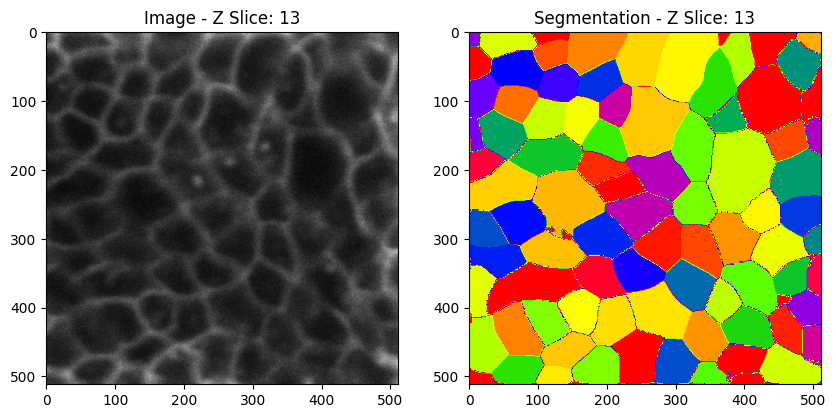

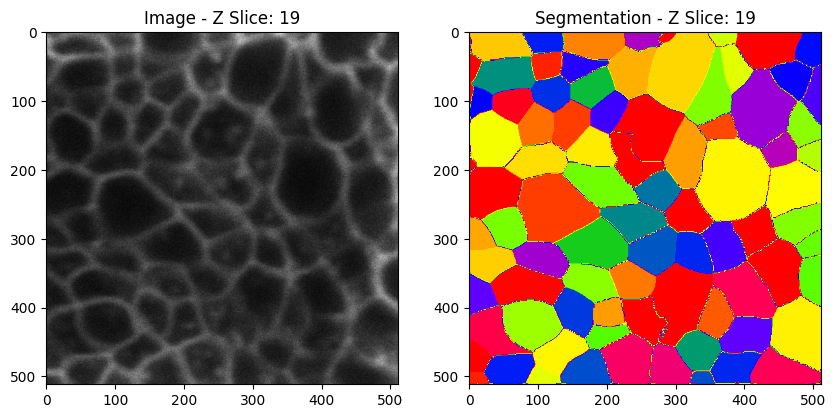

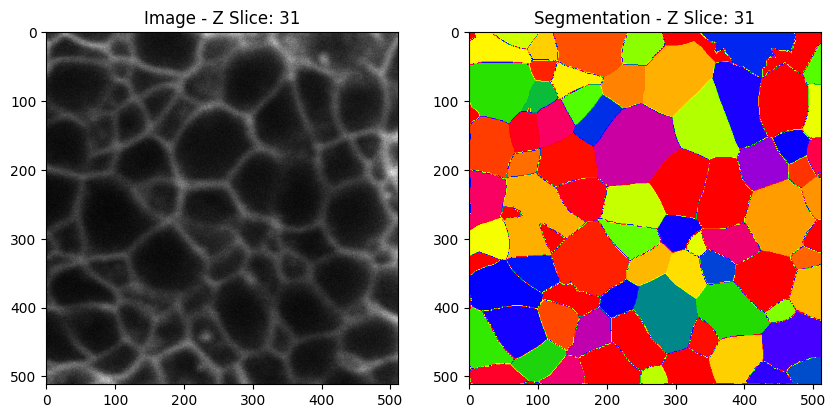

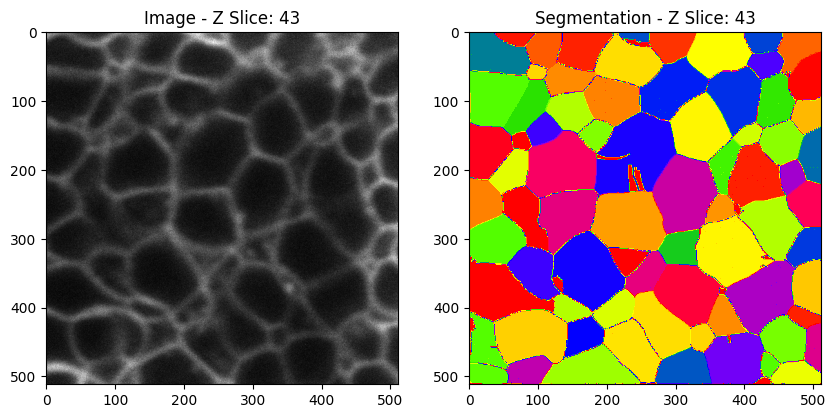

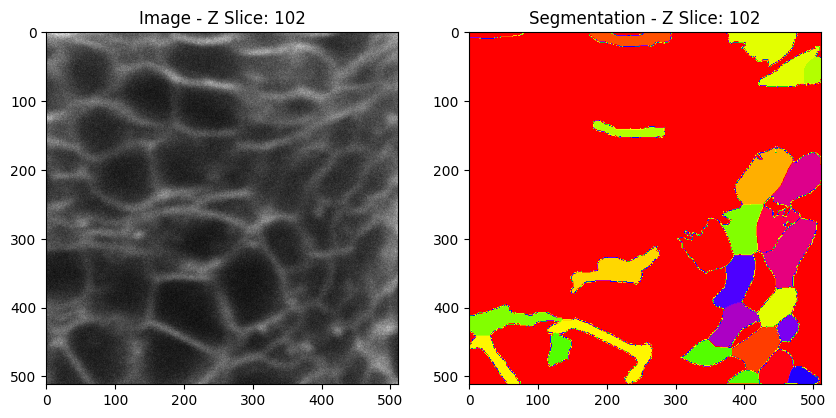

In [85]:
import matplotlib

def visualize_3d_sections(image, masks, segmented=True, num_sections=5):
    """
    Visualizes different random sections of the 3D image and its segmentation.

    Args:
        image: A 3D numpy array representing the image.
        masks: A 3D numpy array representing the cell masks.
        num_sections: The number of random sections to visualize.
    """

    z_dim = image.shape[0]

    # Generate 'num_sections' random numbers
    random_sections = np.random.randint(0, z_dim, num_sections)

    # Sort the random numbers in ascending order
    random_sections = np.sort(random_sections)

    # Create a colormap for all the sections
    cmap = matplotlib.colormaps.get_cmap('prism')

    for id in range(num_sections):
        z_slice = random_sections[id]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image[z_slice], cmap='gray')
        plt.title(f"Image - Z Slice: {z_slice}")

        plt.subplot(1, 2, 2)
        if segmented:
          plt.imshow(masks[z_slice], cmap)
          plt.title(f"Segmentation - Z Slice: {z_slice}")
        else:
          plt.imshow(image[z_slice], cmap='gray')
          plt.title(f"Image - Z Slice: {z_slice}")
        plt.show()

visualize_3d_sections(images[0], masks[0])

(Slow) Visualize the cells in 3D

In [84]:
import numpy as np
import plotly.graph_objects as go
import matplotlib

def visualize_segmented_cells_3d(image, masks):
    """
    Visualizes the segmented cells of a 3D image in a 3D plot using Plotly.

    Args:
        image: A 3D numpy array representing the image.
        masks: A 3D numpy array representing the cell masks.
    """

    # Create a colormap for all the sections
    cmap = matplotlib.colormaps.get_cmap('prism')

    # Create a Plotly figure
    fig = go.Figure()

    # Iterate through each cell mask
    for cell_id in range(1, masks.max() + 1):
        cell_mask = (masks == cell_id)

        # Do not visualize cells smaller than 100 voxels
        if cell_mask.sum() < 100:
            continue

        # Find the coordinates of the cell voxels
        x, y, z = np.where(cell_mask)

        # Plot the cell voxels as a scatter plot
        color = cmap(cell_id / np.max(image))
        rgba_color = f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3]})'
        fig.add_trace(go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(size=1, color=rgba_color, opacity=0.5),
            name=f'Cell {cell_id}'
        ))

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='3D Visualization of Segmented Cells'
    )

    fig.show()

visualize_segmented_cells_3d(images[0], masks[0])

KeyboardInterrupt: 

### (OPTIONAL) Save files

In [ ]:
io.save_masks(images,
              masks,
              flows,
              files,
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs
              save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              )

# 2. Improving raw images for segmentation: Denoising
A very common approach to improve classical segmentation algorithms is to denoise the images. This is done by applying a filter to the images that removes the noise while preserving the structures of interest.
We have tried different denoising algorithms, but none of them improved the segmentation results.

## Deconvolution
TODO: GET SAMPLE DATA DECONVOLVED OR DECONVOLVE IT

In [87]:
from cellpose import denoise

# Select the denoise model
dn = denoise.DenoiseModel(model_type="denoise_cyto3", gpu=True)

# Gets image files in directory (ignoring image files ending in _masks)
files = io.get_image_files(input_dir, '_masks')
images = [io.imread(f) for f in files]

# Compute the denoised images
imgs_dn = dn.eval(imgs, channels=None, diameter=None)

# Visualize some random sections
visualize_3d_sections(images[0], imgs_dn[0], segmented=False)

2024-11-05 11:49:06,802 [INFO] >> denoise_cyto3 << model set to be used
2024-11-05 11:49:06,807 [INFO] ** TORCH CUDA version installed and working. **
2024-11-05 11:49:06,808 [INFO] >>>> using GPU (CUDA)
2024-11-05 11:49:06,910 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-11-05 11:49:06,935 [INFO] reading tiff with 105 planes


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 5709.64it/s]

2024-11-05 11:49:06,982 [INFO] reading tiff with 36 planes



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 4392.32it/s]

2024-11-05 11:49:07,012 [INFO] reading tiff with 38 planes



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 2235.17it/s]

2024-11-05 11:49:07,045 [INFO] reading tiff with 60 planes



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 4694.77it/s]


NameError: name 'imgs' is not defined

We can also do it at the same time and we seem to obtain better results

In [82]:
from cellpose import denoise

# Denoise model
model = denoise.CellposeDenoiseModel(gpu=True, model_type="cyto3",
             restore_type="denoise_cyto3", chan2_restore=True)

# Gets image files in directory (ignoring image files ending in _masks)
files = io.get_image_files(input_dir, '_masks')
images = [io.imread(f) for f in files]

# Compute improved masks
masks, flows, styles, imgs_dn = model.eval(images, channels=[0,0], diameter=None)

2024-11-05 11:38:02,135 [INFO] >> denoise_cyto3 << model set to be used
2024-11-05 11:38:02,151 [INFO] ** TORCH CUDA version installed and working. **
2024-11-05 11:38:02,153 [INFO] >>>> using GPU (CUDA)
2024-11-05 11:38:02,260 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
loading model for chan2: denoise_nuclei
2024-11-05 11:38:02,374 [INFO] >> cyto3 << model set to be used
2024-11-05 11:38:02,376 [INFO] ** TORCH CUDA version installed and working. **
2024-11-05 11:38:02,377 [INFO] >>>> using GPU (CUDA)


/home/pablo/mambaforge/envs/colab_cellpose/lib/python3.10/site-packages/cellpose/resnet_torch.py:271: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



2024-11-05 11:38:02,432 [INFO] >>>> loading model /home/pablo/.cellpose/models/cyto3
2024-11-05 11:38:02,479 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-11-05 11:38:02,504 [INFO] reading tiff with 105 planes


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 5361.34it/s]

2024-11-05 11:38:02,545 [INFO] reading tiff with 36 planes



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 4436.85it/s]

2024-11-05 11:38:02,583 [INFO] reading tiff with 38 planes



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 4765.97it/s]

2024-11-05 11:38:02,606 [INFO] reading tiff with 60 planes



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 3306.16it/s]

2024-11-05 11:38:02,628 [INFO] 0%|          | 0/4 [00:00<?, ?it/s]
2024-11-05 11:38:02,629 [WARNING] z_axis not specified, assuming it is dim 0
2024-11-05 11:38:02,629 [WARNING] if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
2024-11-05 11:38:02,631 [INFO] multi-stack tiff read in as having 105 planes 1 channels


2024-11-05 11:38:02,864 [INFO] 
2024-11-05 11:38:02,865 [INFO] 0%|          | 0/105 [00:00<?, ?it/s]
2024-11-05 11:38:02,866 [INFO] 
2024-11-05 11:38:09,633 [INFO] 100%|##########| 105/105 [00:06<00:00, 15.52it/s]
2024-11-05 11:38:09,676 [INFO] imgs denoised in 6.91s
2024-11-05 11:38:09,702 [WARNING] z_axis not specified, assuming it is dim 0
2024-11-05 11:38:09,703 [WARNING] if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
2024-11-05 11:38:09,704 [INFO] multi-stack tiff read in as having 36 planes 1 channels
2024-11-05 11:38:09,901 [INFO] 
2024-11-05 11:38:09,902 [INFO] 0%|          | 0/36 [00:00<?, ?it/s]
2024-11-05 11:38:09,903 [INFO] 
2024-11-05 11:38:12,226 [INFO] 100%|##########| 36/36 [00:02<00:00, 15.50it/s]
2024-11-05 11:38:12,241 [INFO] imgs denoised in 2.49s
2024-11-05 11:38:12,257 [WARNING] z_axis not specified, assuming it is dim 0
2024-11-05 11:38:12,258 [WARNING] if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
2024-1


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 131.26it/s]


2024-11-05 11:39:08,800 [INFO] masks created in 41.88s
2024-11-05 11:39:10,263 [INFO] 25%|##5       | 1/4 [00:51<02:33, 51.24s/it]
2024-11-05 11:39:10,264 [WARNING] z_axis not specified, assuming it is dim 0
2024-11-05 11:39:10,265 [WARNING] if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
2024-11-05 11:39:10,265 [INFO] multi-stack tiff read in as having 36 planes 1 channels
2024-11-05 11:39:10,529 [INFO] 
2024-11-05 11:39:10,530 [INFO] 0%|          | 0/36 [00:00<?, ?it/s]
2024-11-05 11:39:10,531 [INFO] 
2024-11-05 11:39:13,107 [INFO] 100%|##########| 36/36 [00:02<00:00, 13.98it/s]
2024-11-05 11:39:13,109 [INFO] network run in 2.58s
2024-11-05 11:39:13,110 [INFO] 
2024-11-05 11:39:13,111 [INFO] 0%|          | 0/36 [00:00<?, ?it/s]
2024-11-05 11:39:13,112 [INFO] 
2024-11-05 11:39:26,005 [INFO] 100%|##########| 36/36 [00:12<00:00,  2.79it/s]
2024-11-05 11:39:26,007 [INFO] stitching 36 planes using stitch_threshold=0.050 to make 3D masks



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 469.52it/s]


2024-11-05 11:39:27,483 [INFO] masks created in 14.37s
2024-11-05 11:39:27,799 [WARNING] z_axis not specified, assuming it is dim 0
2024-11-05 11:39:27,800 [WARNING] if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
2024-11-05 11:39:27,800 [INFO] multi-stack tiff read in as having 38 planes 1 channels
2024-11-05 11:39:28,063 [INFO] 
2024-11-05 11:39:28,064 [INFO] 0%|          | 0/38 [00:00<?, ?it/s]
2024-11-05 11:39:28,065 [INFO] 
2024-11-05 11:39:30,815 [INFO] 100%|##########| 38/38 [00:02<00:00, 13.83it/s]
2024-11-05 11:39:30,816 [INFO] network run in 2.76s
2024-11-05 11:39:30,817 [INFO] 
2024-11-05 11:39:30,819 [INFO] 0%|          | 0/38 [00:00<?, ?it/s]
2024-11-05 11:39:30,820 [INFO] 
2024-11-05 11:39:42,951 [INFO] 100%|##########| 38/38 [00:12<00:00,  3.13it/s]
2024-11-05 11:39:42,952 [INFO] stitching 38 planes using stitch_threshold=0.050 to make 3D masks



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 844.11it/s]


2024-11-05 11:39:43,737 [INFO] masks created in 12.92s
2024-11-05 11:39:44,062 [INFO] 75%|#######5  | 3/4 [01:25<00:25, 25.80s/it]
2024-11-05 11:39:44,063 [WARNING] z_axis not specified, assuming it is dim 0
2024-11-05 11:39:44,064 [WARNING] if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
2024-11-05 11:39:44,065 [INFO] multi-stack tiff read in as having 60 planes 1 channels
2024-11-05 11:39:44,255 [INFO] 
2024-11-05 11:39:44,256 [INFO] 0%|          | 0/60 [00:00<?, ?it/s]
2024-11-05 11:39:44,257 [INFO] 
2024-11-05 11:39:48,585 [INFO] 100%|##########| 60/60 [00:04<00:00, 13.87it/s]
2024-11-05 11:39:48,586 [INFO] network run in 4.33s
2024-11-05 11:39:48,587 [INFO] 
2024-11-05 11:39:48,588 [INFO] 0%|          | 0/60 [00:00<?, ?it/s]
2024-11-05 11:39:48,588 [INFO] 
2024-11-05 11:40:08,018 [INFO] 100%|##########| 60/60 [00:19<00:00,  3.09it/s]
2024-11-05 11:40:08,018 [INFO] stitching 60 planes using stitch_threshold=0.050 to make 3D masks



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 851.55it/s]


2024-11-05 11:40:09,015 [INFO] masks created in 20.43s
2024-11-05 11:40:09,632 [INFO] 100%|##########| 4/4 [01:50<00:00, 27.65s/it]


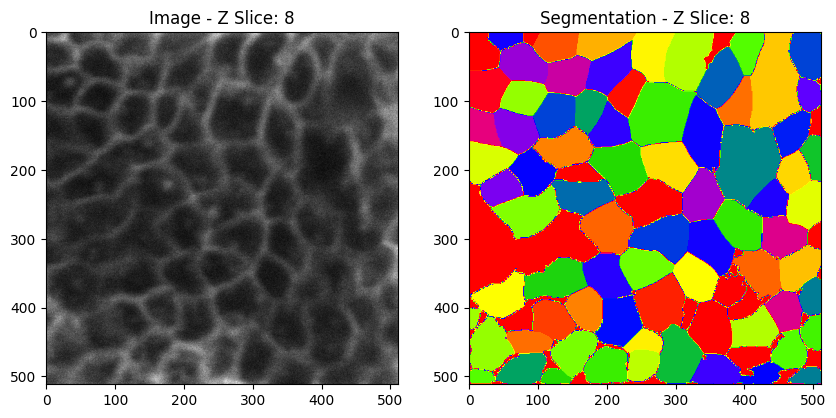

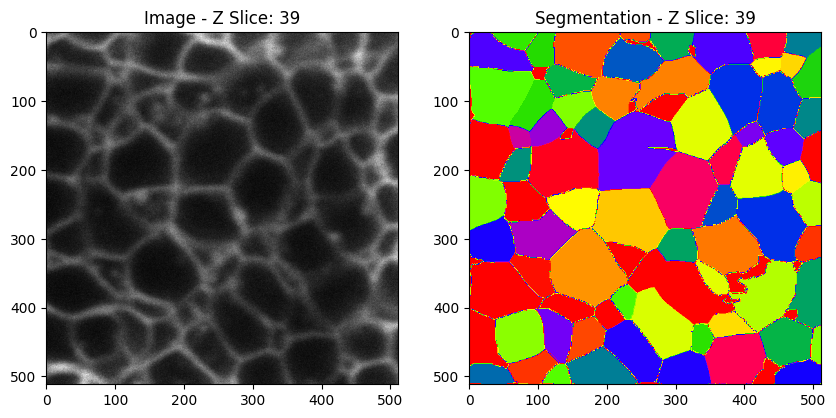

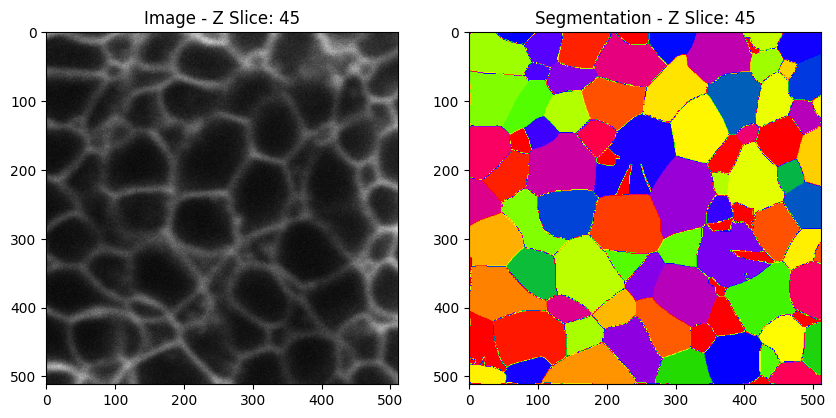

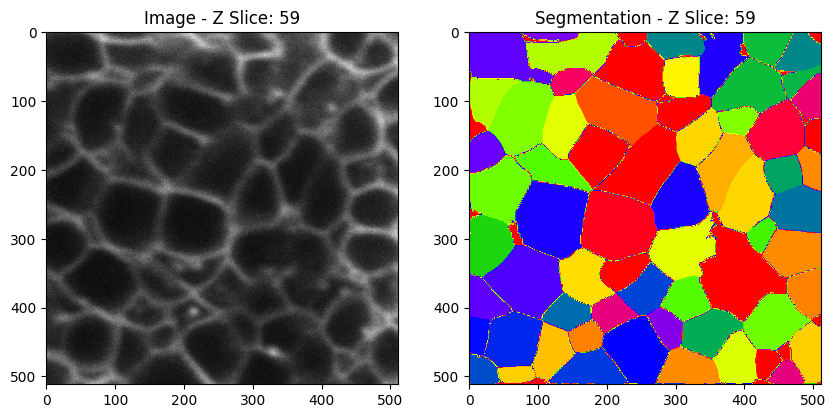

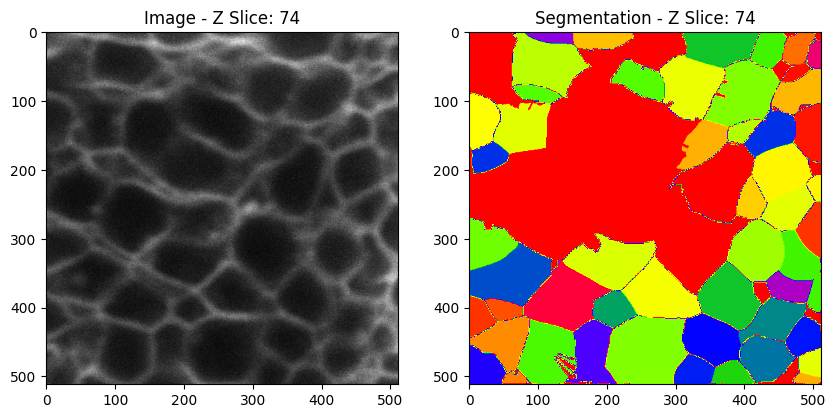

In [83]:
visualize_3d_sections(images[0], masks[0])

# 3. Refining the segmentation: Cellpose fine-tuning
Cellpose fine-tuning is a feature that allows you to improve the segmentation results by training a new model on your own data.

### From 3D images to 2D images

In [63]:
# Code developed by Alvaro Miranda de Larra and Pablo Vicente-Munuera
import os
import tifffile as tiff

def iterative_image_splicer(input_dir, output_dir, segmented_input=False):

  # Create the output directory if it doesn't exist
  os.makedirs(output_dir, exist_ok=True)

  # Get a list of all .tif files in the input directory
  tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

  # Iterate over each 3D image
  for tif_file in tif_files:
    if not tif_file.startswith('.'):
      # Load the multi-directory TIFF image
      with tiff.TiffFile(os.path.join(input_dir, tif_file)) as tif:
          image = tif.asarray()

      # Get the shape of the 3D image
      z, y, x = image.shape
      print(image.shape)
      # Generate 2D images along XY, XZ, and YZ coordinates

      for z_coord in range(z):
          xy_image = image[z_coord, :, :]  # XY plane at the current Z coordinate

          # Save the 2D images with appropriate names
          base_name = os.path.splitext(tif_file)[0]
          # Remove '_segmented' from base_name
          base_name = base_name.replace('_segmented', '')
          if segmented_input:
            tiff.imwrite(os.path.join(output_dir, f'{base_name}_XY_Z{z_coord}_masks.tif'), xy_image)
          else:
            tiff.imwrite(os.path.join(output_dir, f'{base_name}_XY_Z{z_coord}.tif'), xy_image)

      for xy_coord in range(x):
          xz_image = image[:, :, xy_coord]  # XZ plane at the current Y coordinate
          yz_image = image[:, xy_coord, :]  # YZ plane at the current X coordinate

          if segmented_input:
            tiff.imwrite(os.path.join(output_dir, f'{base_name}_XZ_Y{xy_coord}_masks.tif'), xz_image)
            tiff.imwrite(os.path.join(output_dir, f'{base_name}_YZ_X{xy_coord}_masks.tif'), yz_image)
          else:
            tiff.imwrite(os.path.join(output_dir, f'{base_name}_XZ_Y{xy_coord}.tif'), xz_image)
            tiff.imwrite(os.path.join(output_dir, f'{base_name}_YZ_X{xy_coord}.tif'), yz_image)

!rm -rf labelled_data_2D/
iterative_image_splicer('labelled_data/raw/', 'labelled_data_2D')
iterative_image_splicer('labelled_data/segmented/', 'labelled_data_2D', segmented_input=True)

(105, 512, 512)
(36, 512, 512)
(38, 512, 512)
(60, 512, 512)
(60, 512, 512)
(36, 512, 512)
(38, 512, 512)
(105, 512, 512)


what the training images look like + their labels

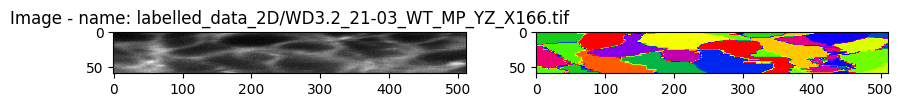

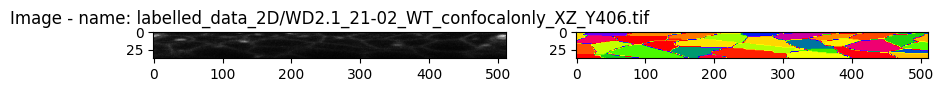

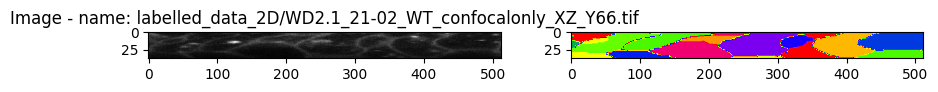

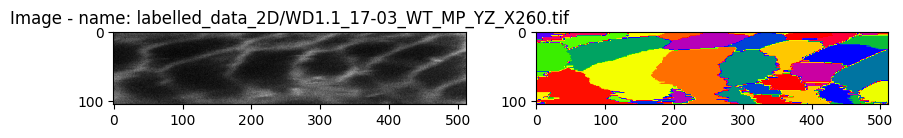

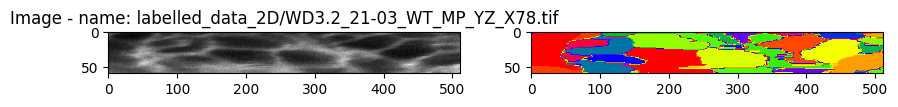

In [71]:
from natsort import natsorted
from glob import glob

train_files = natsorted([f for f in glob('labelled_data_2D/*.tif')
                        if '_masks' not in f])
train_seg = natsorted(glob('labelled_data_2D/*_masks.tif'))

num_images_to_show = 5

# Generate 'num_sections' random numbers
random_sections = np.random.randint(0, len(train_files), num_images_to_show)

# Visualize a few training and segmentation images
for k,f in enumerate(random_sections):
    img = io.imread(train_files[f])
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image - name: {train_files[f]}")

    # Get the corresponding segmentation image
    seg = io.imread(train_seg[f])
    plt.subplot(1, 2, 2)
    plt.imshow(seg, cmap='prism')
    plt.show()


### Split into training and set test


In [75]:
!rm -rf test/
!rm -rf train/

# Divide sets into training and set test
from sklearn.model_selection import train_test_split

train_files = natsorted([f for f in glob('labelled_data_2D/*.tif')
                        if '_masks.tif' not in f])
train_files, test_files = train_test_split(train_files, test_size=0.2, random_state=42)

# Save files from train into 'train'
os.makedirs('train', exist_ok=True)
for f in train_files:
    shutil.copy(f, 'train')
    # Get the '_mask' from the file f
    shutil.copy(f.replace('.tif', '_masks.tif'), 'train')

# Save files from test into 'test'
os.makedirs('test', exist_ok=True)
for f in test_files:
    shutil.copy(f, 'test')
    # Get the '_mask' from the file f
    shutil.copy(f.replace('.tif', '_masks.tif'), 'test')

### Train model on manual annotations

Skip this step if you already have a pretrained model.

Fill out the form below with the paths to your data and the parameters to start training.

### Training parameters

<font size = 4> **Paths for training, predictions and results**


<font size = 4>**`train_dir:`, `test_dir`:** These are the paths to your folders train_dir (with images and masks of training images) and test_dir (with images and masks of test images). You can leave the test_dir blank, but it's recommended to have some test images to check the model's performance. To find the paths of the folders containing the respective datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

<font size = 4>**`initial_model`:** Choose a model from the cellpose [model zoo](https://cellpose.readthedocs.io/en/latest/models.html#model-zoo) to start from.

<font size = 4>**`model_name`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 4>**Training parameters**

<font size = 4>**`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. At least 100 epochs are recommended, but sometimes 250 epochs are necessary, particularly from scratch. **Default value: 100**



In [76]:
#@markdown ###Path to images and masks:

train_dir = "train" #@param {type:"string"}
test_dir = "test" #@param {type:"string"}
#Define where the patch file will be saved
base = "/content"

# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from cellpose import models
initial_model = "cyto3" #@param ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "CP_improved" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  100#@param {type:"number"}

Channel_to_use_for_training = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:
learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001

#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


Here's what the command to train would be on the command line -- make sure if you run this locally to correct the paths for your local computer.

In [ ]:
run_str = f'python -m cellpose --use_gpu --verbose --train --dir {train_dir} --pretrained_model {initial_model} --chan {chan} --chan2 {chan2} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay}'
if test_dir is not None:
    run_str += f' --test_dir {test_dir}'
#run_str += ' --mask_filter _seg.npy' # if you want to use _seg.npy files for training
print(run_str)

### Train new model

Using settings from form above, train model in notebook.

In [77]:
from cellpose import train

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='')
train_data, train_labels, _, test_data, test_labels, _ = output

(new_model_path, train_losses, test_losses) = train.train_seg(model.net, train_data=train_data,
                              train_labels=train_labels,
                              test_data=test_data,
                              test_labels=test_labels,
                              save_path=train_dir,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()

2024-11-05 11:01:13,645 [INFO] WRITING LOG OUTPUT TO /home/pablo/.cellpose/run.log
2024-11-05 11:01:13,646 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.10.15 
torch version:  	2.5.1+cu124
2024-11-05 11:01:13,647 [INFO] >> cyto3 << model set to be used
2024-11-05 11:01:13,667 [INFO] ** TORCH CUDA version installed and working. **
2024-11-05 11:01:13,668 [INFO] >>>> using GPU (CUDA)
2024-11-05 11:01:13,743 [INFO] >>>> loading model /home/pablo/.cellpose/models/cyto3
2024-11-05 11:01:13,793 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


/home/pablo/mambaforge/envs/colab_cellpose/lib/python3.10/site-packages/cellpose/resnet_torch.py:271: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



2024-11-05 11:01:14,059 [INFO] not all flows are present, running flow generation for all images
2024-11-05 11:01:15,783 [INFO] 3468 / 3468 images in train folder have labels
2024-11-05 11:01:15,844 [INFO] not all flows are present, running flow generation for all images
2024-11-05 11:01:16,278 [INFO] 867 / 867 images in test folder have labels
2024-11-05 11:01:16,281 [INFO] computing flows for labels


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3468/3468 [12:59<00:00,  4.45it/s]

2024-11-05 11:14:16,001 [INFO] computing flows for labels



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 867/867 [03:23<00:00,  4.27it/s]

2024-11-05 11:17:39,220 [INFO] >>> computing diameters



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 867/867 [00:00<00:00, 5548.17it/s]

2024-11-05 11:17:39,928 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}
2024-11-05 11:17:39,928 [CRITICAL] Image needs to have at least 3 dimensions


ValueError: Image needs to have at least 3 dimensions

## Evaluate on test data (optional)

If you have test data, check performance

In [ ]:
# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, mask_filter='')
test_data, test_labels = output[:2]

# run model on test images
masks = model.eval(test_data,
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]

print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')
print(f'>>> average precision at iou threshold 0.75 = {ap[:,1].mean():.3f}')
print(f'>>> average precision at iou threshold 0.95 = {ap[:,2].mean():.3f}')


In [ ]:

plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(test_data):
    img = im.copy()
    plt.subplot(3,len(train_files), k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
    img = img.transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(train_files), len(train_files) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(train_files), 2*len(train_files) + k+1)
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

# 4. Segmentation evaluation metrics: biology-based
Common metrics used to evaluate the quality of a segmentation are: IoU (Intersection over Union), Dice coefficient, ... However, these metrics are not always suitable for biological images. We have developed a new metric that is more biologically relevant. It also helped us to improve the segmentation results from our manual annotations.

# 5.Tracking cells in 3D: custom stitching method
We still had issues with our segmentation results, especially when cells were touching each other. Therefore, we used TrackMate to track cells in 3D and then stitched the cells together. This allowed us to obtain a more accurate segmentation of the cells.

# Use custom model to segment images

Take custom trained model from above, or upload your own model to google drive / colab runtime.

## Parameters

if you're using the example test data we'll copy it to a new folder

In [ ]:
src = 'human_in_the_loop/test'
if dir[:len(src)] == src:
    files = io.get_image_files(dir, '_masks')
    dir = 'human_in_the_loop/eval/'
    os.makedirs(dir, exist_ok=True)
    for f in files:
        dst = dir + os.path.split(f)[1]
        print(f'{f} > {dst}')
        shutil.copyfile(f, dst)

Here's what the command to train would be on the command line -- make sure if you run this locally to correct the paths for your local computer.

In [ ]:
run_str = f'python -m cellpose --use_gpu --verbose --dir {dir} --pretrained_model {model_path} --chan {chan} --chan2 {chan2} --diameter {diameter} --flow_threshold {flow_threshold} --cellprob_threshold {cellprob_threshold}'
print(run_str)

## run custom model

how to run the custom model in a notebook

In [ ]:
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=True,
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images,
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

## save output to *_seg.npy

you will see the files save in the Files tab and you can download them from there

In [ ]:
from cellpose import io

io.masks_flows_to_seg(images,
                      masks,
                      flows,
                      files,
                      channels=[chan, chan2],
                      diams=diameter*np.ones(len(masks)),
                      )

## save output masks to tiffs/pngs or txt files for imageJ

In [ ]:
io.save_masks(images,
              masks,
              flows,
              files,
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs
              save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              )


In [ ]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output.png'))
plt.axis('off')